In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
plt.style.use('ggplot')

In	this	post,	we	will	build	a	network	that	can	recognize	handwritten	numbers.	For	achieving	this	goal, we	use	MNIST	(for	more	information,	refer	to	http://yann.lecun.com/exdb/mnist/),	a	database	of	handwritten	digits .
The MNIST dataset contains the 28x28 pixel images of handwritten digits from 0 to 9, and their labels, 55K for the training set and 10K for the test set and remaining 5K for validation. The MNIST dataset is the most widely used data set, including in TensorFlow examples and tutorials. 

In [3]:
# load MNIST dataset
mnist_data = input_data.read_data_sets('MNIST_data', reshape = False, one_hot =  True)
print()
print('mnist_data is: ', type(mnist_data))

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz

mnist_data is:  <class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>


mnist_data contains images and their labels for both training and testing. Let's see what are the shapes of these sets.

In [4]:
print('Shape of training set is {}.' .format(mnist_data.train.images.shape))
print('Shape of one-hot labels for training set is {}.'.format(mnist_data.train.labels.shape))

Shape of training set is (55000, 28, 28, 1).
Shape of one-hot labels for training set is (55000, 10).


We can see that our training set has 55000 28x28 images. The labels are one-hot vectors, that's why the shape of labels matrix is (55000, 10).
Now we will see what are dimensions for testing data?

In [5]:
print('Shape of testing set is {}.' .format(mnist_data.test.images.shape))
print('Shape of one-hot labels for testing set is {}.'.format(mnist_data.test.labels.shape))

Shape of testing set is (10000, 28, 28, 1).
Shape of one-hot labels for testing set is (10000, 10).


The remainig 5000 images are used for validation.


In [6]:
print('Shape of validation set is {}.' .format(mnist_data.validation.images.shape))
print('Shape of one-hot labels for validation set is {}.'.format(mnist_data.validation.labels.shape))

Shape of validation set is (5000, 28, 28, 1).
Shape of one-hot labels for validation set is (5000, 10).


In [7]:
X_train, y_train = mnist_data.train.images, mnist_data.train.labels
X_test, y_test = mnist_data.test.images, mnist_data.test.labels
X_validation, y_validation = mnist_data.validation.images, mnist_data.validation.labels

In [8]:
image_5th = X_train[5]
label_5th = y_train[5]
print(type(image_5th))
print(image_5th.shape)
print(type(label_5th))
print(label_5th.shape)

<class 'numpy.ndarray'>
(28, 28, 1)
<class 'numpy.ndarray'>
(10,)


Let's now plot one image from training dataset.

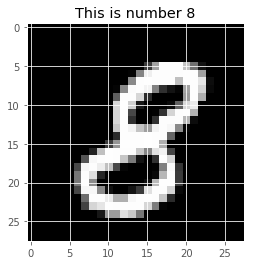

In [9]:
plt.imshow(image_5th.squeeze(), cmap = 'gray')
plt.title('This is number ' + str(np.argmax(label_5th)))
plt.show()

We know that LeNet-5 paper uses 32x32 images, and here we have 28x28 images, so we will now pad these images to get images of size 32x32. More about padding you can see in these posts...links

In [10]:
X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test= np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')

In [11]:
print('Shape of training set is {}.' .format(X_train.shape))
print('Shape of testing set is {}.' .format(X_test.shape))
print('Shape of validation set is {}.' .format(X_validation.shape))

Shape of training set is (55000, 32, 32, 1).
Shape of testing set is (10000, 32, 32, 1).
Shape of validation set is (5000, 32, 32, 1).


Now, we will make a function that calculates the outputs of LeNet-5 convolutional neural network. LeNet family of models were introduced by Yann LeCun.
Yann	le	Cun	proposed a family	of ConvNets	named	LeNet	trained	for	recognizing	MNIST	handwritten	characters	.	The	key	intuition	here	is	to	have	low-layers	alternating convolution	operations	with	average-pooling	operations.	The	convolution	operations	are	based	on	carefully chosen	local	receptive	fields	with	shared	weights	for	multiple	feature	maps.	Then,	higher	levels	are	fully connected	layers	based	on	a	traditional	MLP	with	hidden	layers	and	softmax	as	the	output	layer.
	

In [12]:
def LeNet(X):
    
    W1 = tf.Variable(tf.random_normal([5,5,1,6])*0.01)
    b1 = tf.Variable(tf.zeros([6]))
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'VALID')
    A1 = tf.nn.relu(Z1+b1)
    
    P1 = tf.nn.avg_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    W2 = tf.Variable(tf.random_normal([5,5,6,16])*0.01)
    b2 = tf.Variable(tf.zeros([16]))
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'VALID')
    A2 = tf.nn.relu(Z2+b2)
    
    P2 = tf.nn.avg_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    P = tf.contrib.layers.flatten(P2)
        
    W3 = tf.Variable(tf.random_normal([400,120])*0.01)
    b3 = tf.Variable(tf.zeros([120]))
    Z3 = tf.matmul(P, W3)
    A3 = tf.nn.relu(Z3+b3)
    
    W4 = tf.Variable(tf.random_normal([120,84])*0.01)
    b4 = tf.Variable(tf.zeros([84]))
    Z4 = tf.matmul(A3, W4)
    A4 = tf.nn.relu(Z4+b4)
    
    W5 = tf.Variable(tf.random_normal([84,10])*0.01)
    b5 = tf.Variable(tf.zeros([10]))
    Z5 = tf.matmul(A4, W5)
    A5 = Z5 # we don't use softmax function here becauce softmax_cross_entropy_with_logits() 
            # internally uses softmax to scale the output
    
    logits = A5
    
    return logits

A placeholder is a tensor where the data will be passed. These Tensorflow object aren't specific values but will recive input during computation. So, those are elements where labels or targets will be supplies. By defining placeholders in the folllowing way we allow our program to calculate the following opperations for a single image, a batch of images or for the hole set.

In [13]:
# defing placeholders
x_input = tf.placeholder(tf.float32, (None,32,32,1)) # here None means any shape
y_input = tf.placeholder(tf.float32, (None,10)) # y is for one-hot labels

This function computes the softmax entropy between the model (the estimated value logits) and the actual value of y_input. The entropy function is used when the output belongs to one class and not more than one class. As in our example, the image can only belong to one of the digits.

In [14]:
logits = LeNet(x_input)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y_input))
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
training = optimizer.minimize(loss_op)

In [15]:
correct_predicitons = tf.equal(tf.argmax(logits, 1), tf.argmax(y_input, 1))
accuracy_opp = tf.reduce_mean(tf.cast(correct_predicitons, tf.float32))

In [21]:
num_epochs = 20
num_batch = 200
batch_size = 128
num_examples = X_train.shape[0]
accuracy = []
loss_all = []
val_all = []

saver = tf.train.Saver()

X_train, y_train = shuffle(X_train, y_train)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer()) # variables initialization
    for i in range(num_epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for delta in range(0, num_examples, batch_size): # training in batches
            end = delta + batch_size
            X_batch = X_train[delta:end]
            y_batch = y_train[delta:end]
            
            _, acc_batches, loss = sess.run([training, accuracy_opp, loss_op], feed_dict = {x_input : X_batch,
                                                                                                y_input : y_batch})
            accuracy.append(acc_batches)
            loss_all.append(loss)
        
        val = sess.run(accuracy_opp,feed_dict = {x_input : X_validation,y_input : y_validation})
        val_all.append(val)
           
    
    accuracy_train, loss_train = sess.run([accuracy_opp, loss_op], feed_dict = {x_input : X_train,
                                                                                y_input : y_train})      
    
    accuracy_test, loss_test = sess.run([accuracy_opp, loss_op], feed_dict = {x_input : X_test,
                                                                              y_input : y_test})  
    
    print('Accuracy on training set is: %0.4f and loss is %.4f.' %(accuracy_train, loss_train))
    print('Accuracy on testing set is: %0.4f and loss is %.4f.'%(accuracy_test, loss_test))

    
    saver.save(sess, "/tmp/model.ckpt")

Accuracy on training set is: 0.9945 and loss is 0.0165.
Accuracy on testing set is: 0.9867 and loss is 0.0490.


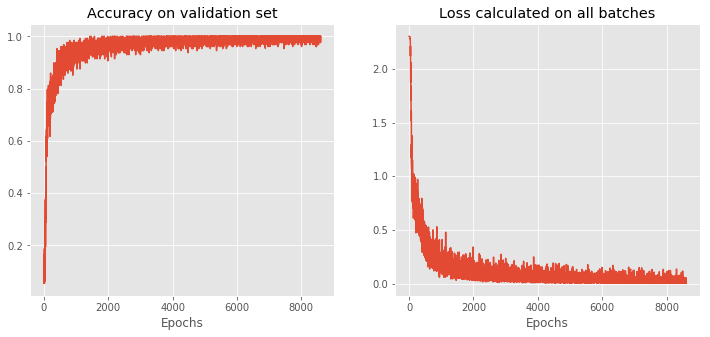

In [25]:
plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(np.linspace(0,len(accuracy), len(accuracy)), accuracy)
plt.title('Accuracy on validation set')
plt.xlabel('Epochs')
plt.subplot(122)
plt.plot(np.linspace(0,len(loss_all), len(loss_all)), loss_all)
plt.title('Loss calculated on all batches')
plt.xlabel('Epochs')
plt.show()

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


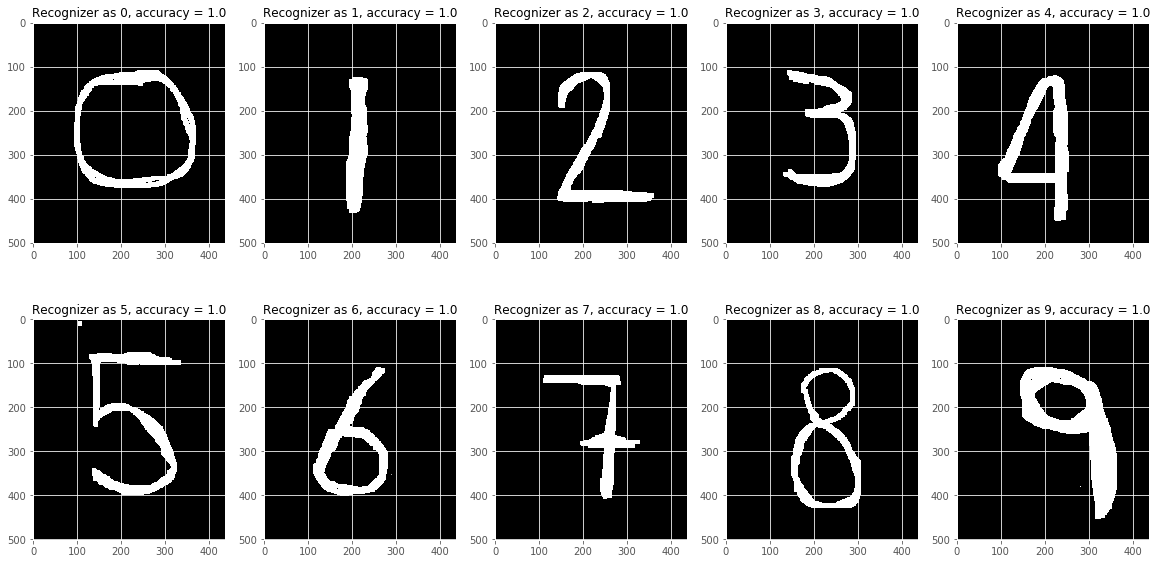

In [34]:
labels_onehot = np.eye(10)
fig = plt.figure(figsize=(20, 10))

with tf.Session() as sess:
    saver.restore(sess, "/tmp/model.ckpt")
    
    for i in range(10):
        
        image = plt.imread('num_'+str(i)+'.png')
        image_re = cv2.resize(image, (32,32))
        gray_image = cv2.cvtColor(image_re, cv2.COLOR_BGR2GRAY)
        image_final = gray_image.reshape(1,32,32,1)
        
        acc, l=sess.run([accuracy_opp, logits], feed_dict={x_input: image_final,
                                       y_input: labels_onehot[i].reshape(1,10).astype('float32')})
        
        plt.subplot(2,5,int(i+1))
        plt.imshow(image, cmap='gray')
        plt.title('Recognizer as ' + str(np.argmax(l))+ ', accuracy = '+ str(acc), fontsize = 12)
    plt.show()